# RcTorch 2022 AITOOLs submission Notebook
## Exact solutions: 1st order  Linear ODE's

In [1]:
#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from rctorch import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time
import matplotlib.gridspec as gridspec

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

In [2]:
lineW = 3
lineBoxW=2

font = {'family' : 'normal',
        'weight' : 'normal',#'bold',
        'size'   : 24}

plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

### This notebook contains the solutions to the linear first order explicitily time-dependent equation   of the form $\dot y + q(t) y = f(t) $.

Specifically we solve three related differential equations:
1) Simple population:  <font color='blue'>$\dot y + y =0$  </font>
* Analytical solution: <font color='green'>$y = y_0 e^{-t}$</font>

2) Driven population:  <font color='blue'>$\dot y + y + \sin(t) =0$ </font>
* Analytical solution: <font color='green'>$y = e^{-t}\left(y_0 + \frac{1}{2}\right) + \frac{1}{2}\left( \sin(t) - \cos(t) \right)$ </font>

3) Driven population with nonlinear time dependence:  <font color='blue'> $\dot y + t^2 y + \sin(t) =0$  </font>
* Analytical solution: None

### Limitations:
    Only the first initial condition can vary.

## helper functions

In [3]:
def plot_predictions(RC, results, integrator_model, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.cpu()
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        y = y.cpu()
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        ax.plot(X, y, color = "dodgerblue", label = labels[0], linewidth = lineW + 1, alpha = 0.9)

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "red", alpha = 0.9, label = labels[1],  linewidth = lineW)
    
    plt.ylabel(r'$y(t)$');
    ax.legend();
    ax.tick_params(labelbottom=False)
    plt.tight_layout()

def convert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    Returns
    -------
    ode_coefs
    """
    #print("ode coefs", ode_coefs)
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = re.sub("[^0-9.-]+", "", coef)
                pow_ = float(pow_)
                ode_coefs[i]  = t ** pow_
                print("altering ode_coefs")
        elif type(coef) in [float, int, type_t]:
            pass
        else:
            #print("invalid coef:",type(coef))
            assert False, "ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    
    #copy the returned value to prevent over-writing it later.
    return ode_coefs.copy()
    

def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    Returns
    -------
    None
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.cpu()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    force_t = force(X)
    ode_coefs = convert_ode_coefs(t = X, ode_coefs = RC.ode_coefs)
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = y.cpu()
        ydot = ydot.cpu()
        
        
        
        resids = custom_loss(X, y, ydot, None, 
                             force_t = force_t, 
                             ode_coefs = RC.ode_coefs,
                             mean = False)
        if not i:
            resids_tensor = resids
            label = r'{Individual Trajectory RMSR}'
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
            label = None
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, color = "orangered", alpha = 0.4, label = label, linewidth = lineW-1)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
    ax.plot(X, rmsr, 
               color = "blue", 
               alpha = 0.9, 
               label = r'{RMSR}',
               linewidth = lineW-0.5)

    ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'{RMSR}')

def driven_force(X, A = 1):
    """ a force function, specifically f(t) = sin(t)
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, a torch.tensor of equal dimension to the input time tensor.
    """
    return A * torch.sin(X)

def no_force(X):
    """ a force function (returns 0)
    
    Parameters
    ----------
    X: torch.tensor
        the input time tensor
    
    Returns
    -------
    the force, in this case 0.
    """
    return 0

#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    """ A reparameterization function, specifically g= 1-e^(-t)
    Parameters
    ----------
    t: torch.tensor
        the input time tensor
    order:
        the ODE order
    
    Returns:
    g: torch.tensor
        the reparameterization of t which satisfies the initial conditions
    g_dot: torch.tensor
        the time derivative of g
    Returns
    -------
    g, gdot
    """
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot
    
    #first derivative
    
    
    #example code for higher derivatives:
    #####################################
    
    #derivatives_of_g.append(g_dot)
    #derivatives_of_g.append(g)
#     for i in range(order):
#         if i %2 == 0:
#             #print("even")
#             derivatives_of_g.append(g_dot)
#         else:
#             #print("odd")
#             derivatives_of_g.append(-g_dot)
#    return derivatives_of_g


#simple population eq loss
def custom_loss(X, y, ydot, out_weights, 
                enet_strength = None,
                enet_alpha = None,
                ode_coefs = None,
                force_t = None, 
                reg = True, 
                reparam = reparam, 
                init_conds = None,
                mean = True):
    """ The loss function of the ODE (in this case the population equation loss)
    Parameters
    ----------
    X: torch.tensor
        The input (in the case of ODEs this is time t)
    y: torch.tensor
        The response variable
    ydot: torch.tensor
        The time derivative of the response variable
    enet_strength: float
        the magnitude of the elastic net regularization parameter. In this case there is no e-net regularization
    enet_alpha: float
        the proportion of the loss that is L2 regularization (ridge). 1-alpha is the L1 proportion (lasso).
    ode_coefs: list
        this list represents the ODE coefficients. They can be numbers or t**n where n is some real number.
    force: function
        this function needs to take the input time tensor and return a new tensor f(t)
    reg: bool
        if applicable (not in the case below) this will toggle the elastic net regularization on and off
    reparam: function
        a reparameterization function which needs to take in the time tensor and return g and gdot, which 
        is the reparameterized time function that satisfies the initial conditions.
    init_conds: list
        the initial conditions of the ODE.
    mean: bool
        if true return the cost (0 dimensional float tensor) else return the residuals (1 dimensional tensor)
        
    Returns
    -------
    the residuals or the cost depending on the mean argument (see above)
    """
    
    #lam is short for lambda
    lam = ode_coefs[0]
    L =  ydot + lam * y - force_t
    
    L = torch.square(L)
    
    if mean:
        L = torch.mean(L)
    
    return L



In [4]:
BURN_IN = 1000
x0,xf, nsteps = 0, 5, 1000
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

#the length of xtrain won't matter above. Only dt , x0, and xf matter for ODEs.
#the reason for this is that the input time vector is reconstructed internally in rctorch
#in order to satisfy the specified dt.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)

In [5]:
simple_pop_hps = {'dt': 0.0031622776601683794,
 'n_nodes': 250,
 'connectivity': 0.7170604557008349,
 'spectral_radius': 1.5755887031555176,
 'regularization': 0.00034441529823729916,
 'leaking_rate': 0.9272222518920898,
 'bias': 0.1780446171760559}

### declare the initial conditions (each initial condition corresponds to a different curve)


In [6]:
y0s = np.arange(-2, 2.1, 0.5)

#### Train the RC:

In [7]:
xtrain.view(-1,1).shape

torch.Size([1000, 1])

In [8]:
%%time
pop_RC = RcNetwork(**simple_pop_hps,
                   random_state = 209, 
                   dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : no_force, 
              "reparam_f" : reparam,
              #"sample_timepoints" : 1000,
              "ode_coefs" : [1,1]}


results = pop_RC.fit(init_conditions = [y0s,1],
                     train_score = True, 
                     ODE_criterion = custom_loss,
                     **train_args, 
                     random_sampling = False)

CPU times: user 1min 3s, sys: 3.17 s, total: 1min 6s
Wall time: 54.8 s


In [9]:
results["scores"]

[tensor(3.2926e-08),
 tensor(1.8521e-08),
 tensor(8.2314e-09),
 tensor(2.0579e-09),
 tensor(0.),
 tensor(2.0579e-09),
 tensor(8.2314e-09),
 tensor(1.8521e-08),
 tensor(3.2926e-08)]

#### Declare integrator model

In [10]:
#integrator model
def population_model(y, t, t_pow = 0, force_k = 0, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

#### Plot the integrator solutions vs the RC and the RMSR (directly calculated from the loss function)

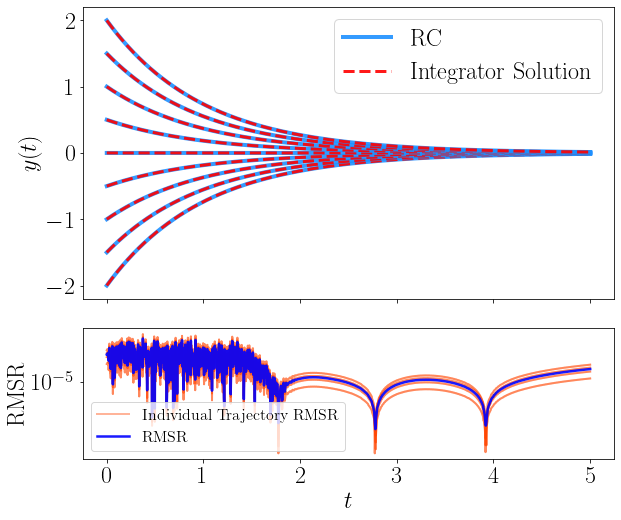

In [11]:
#show results:
fig = plt.figure(figsize = (9,7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

plot_predictions(pop_RC, results, population_model, ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(pop_RC, 
                      results, 
                      force = no_force, 
                      ax = ax)

In [12]:
xtrain.view(-1,).min(), xtrain.view(-1,).max()

(tensor(0.), tensor(5.))

In [13]:
pop_RC.X.view(-1,).min(), pop_RC.X.view(-1,).max()

(tensor(0.), tensor(5.))

In [14]:
# plt.plot(pop_RC.X,pop_RC.X)
# plt.plot(pop_RC.X,xtrain.view(-1,))

# Driven population

#### declare the initial conditions (each initial condition corresponds to a different curve)


In [15]:
y0s = np.arange(-2, 2.1, 0.5)

#### Train the RC

In [16]:
np.log10(0.0031622776601683794)

-2.5

In [17]:
%%time

driven_pop_hps = {'dt': 0.0031622776601683794,
                  'n_nodes': 500,
                  'connectivity': 0.7875262340500385,
                  'spectral_radius': 9.97140121459961,
                  'regularization': 8.656278081920211,
                  'leaking_rate': 0.007868987508118153,
                  'bias': -0.2435922622680664}

#another example: (command + backslash after highlighting will uncomment all the lines at once)
# driven_pop_hps = {'dt': 0.0031622776601683794,
#  'n_nodes': 400,
#  'connectivity': 0.012634199142753764,
#  'spectral_radius': 5.489274978637695,
#  'regularization': 9.489825036097473,
#  'leaking_rate': 0.0023584181908518076,
#  'bias': 0.45648694038391113}

driven_RC = RcNetwork(**driven_pop_hps,
                             random_state = 209,
                             dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [1,1]}

driven_results = driven_RC.fit(init_conditions = [y0s,1],
                 **train_args, 
                 SOLVE = True,
                 train_score = True, 
                 ODE_criterion = custom_loss)

CPU times: user 35.6 s, sys: 2.68 s, total: 38.3 s
Wall time: 41.5 s


#### Declare integrator model

In [18]:
def driven_pop_model(y, t, t_pow = 0, force_k = 1):
    k = 1
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

#### Plot the integrator solutions vs the RC and the RMSR (directly calculated from the loss function)

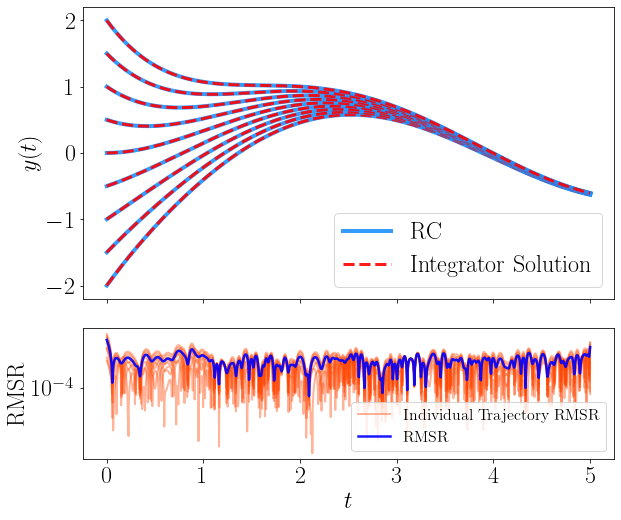

In [19]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])


plot_predictions(RC = driven_RC, 
                 results = driven_results, 
                 integrator_model = driven_pop_model, 
                 ax = ax)
ax = plt.subplot(gs1[-1, :])
plot_rmsr(RC = driven_RC, 
          results = driven_results, 
          force = driven_force, 
          ax = ax)

# Driven population with nonlinear time dependence (t^2)

#### declare the initial conditions (each initial condition corresponds to a different curve)


In [20]:
y0s = np.arange(-2, 2.1, 0.5)

#### Train the RC

In [21]:
#the Bayesian Optimization was run on a power of 2. Feel free to play around with this value. 
pow_ = 2

In [22]:
%%time
t2_hps =  {'n_nodes': 500,
           'connectivity': 0.09905712745750006,
           'spectral_radius': 1.8904799222946167,
           'regularization': 714.156090350679,
           'leaking_rate': 0.031645022332668304,
           'bias': -0.24167031049728394,
           'dt' : 0.005}



t2_RC = RcNetwork(**t2_hps,
                         random_state = 209, 
                         dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [f"t**{pow_}", 1]}


t2_results = t2_RC.fit(init_conditions = [y0s,1],
                       SOLVE = True,
                       train_score = True, 
                       ODE_criterion = custom_loss,
                       **train_args)

CPU times: user 12.3 s, sys: 1.68 s, total: 14 s
Wall time: 21.6 s


#### Declare integrator model

In [23]:
def driven_pop_model_t2(y, t, t_pow = pow_, force_k = 1):
    k = 1
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

#### Plot the integrator solutions vs the RC and the RMSR (directly calculated from the loss function)

altering ode_coefs


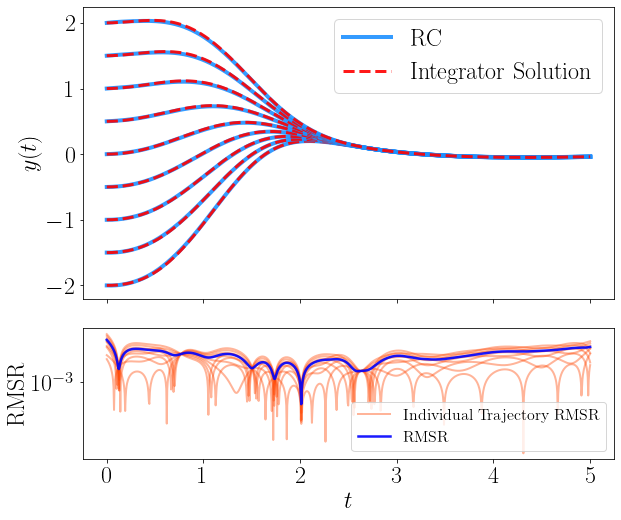

In [24]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

gts = plot_predictions(RC = t2_RC, 
                       results = t2_results, 
                       integrator_model = driven_pop_model_t2, 
                       ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(t2_RC, 
                      results = t2_results, 
                      force = driven_force, 
                      ax = ax)

In [25]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')

Total notebook runtime: 120.78 seconds
